In [1]:
%cd ..

/sunjinsheng/sunpiece/mar


In [2]:
# MAR imports:
import torch
import numpy as np
from models import mar
from models.vae import AutoencoderKL
from torchvision.utils import save_image
from util import download
from PIL import Image
from IPython.display import display
from safetensors.torch import load_file
torch.set_grad_enabled(False)
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    print("GPU not found. Using CPU instead.")

# 2. Load and download pre-trained MAR models

In [3]:
model_type = "mar_huge" #@param ["mar_base", "mar_large", "mar_huge"]
num_sampling_steps_diffloss = 100 #@param {type:"slider", min:1, max:1000, step:1}
if model_type == "mar_base":
  # download.download_pretrained_marb(overwrite=False)
  diffloss_d = 6
  diffloss_w = 1024
elif model_type == "mar_large":
  # download.download_pretrained_marl(overwrite=False)
  diffloss_d = 8
  diffloss_w = 1280
elif model_type == "mar_huge":
  # download.download_pretrained_marh(overwrite=False)
  diffloss_d = 12
  diffloss_w = 1536
else:
  raise NotImplementedError
model = mar.__dict__[model_type](
  buffer_size=64,
  diffloss_d=diffloss_d,
  diffloss_w=diffloss_w,
  num_sampling_steps=str(num_sampling_steps_diffloss)
).to(device)
# ckpt = load_file('checkpoints/mar/mar-huge.safetensors', device='cuda')
# model.load_state_dict(ckpt)
model.eval() # important!
vae = AutoencoderKL(embed_dim=16, ch_mult=(1, 1, 2, 2, 4), ckpt_path=None).cuda()
# ckpt = load_file('checkpoints/mar/kl16.safetensors', device='cuda')
# vae.load_state_dict(ckpt)
vae.eval()

Working with z of shape (1, 16, 16, 16) = 4096 dimensions.


AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down): ModuleList(
      (0-1): 2 x Module(
        (block): ModuleList(
          (0-1): 2 x ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
        (attn): ModuleList()
        (downsample): Downsample(
          (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
        )
      )
      (2): Module(
        (block): ModuleList(
          (0): ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
         

In [4]:
# Set user inputs:
seed = 0 #@param {type:"number"}
torch.manual_seed(seed)
np.random.seed(seed)
num_ar_steps = 64 #@param {type:"slider", min:1, max:256, step:1}
cfg_scale = 4 #@param {type:"slider", min:1, max:10, step:0.1}
cfg_schedule = "constant" #@param ["linear", "constant"]
temperature = 1.0 #@param {type:"slider", min:0.9, max:1.1, step:0.01}
class_labels = 207, 360, 388, 113, 355, 980, 323, 979 #@param {type:"raw"}
samples_per_row = 4 #@param {type:"number"}

In [ ]:
with torch.amp.autocast('cuda'):
  sampled_tokens = model.sample_tokens(
      bsz=len(class_labels), num_iter=num_ar_steps,
      cfg=cfg_scale, cfg_schedule=cfg_schedule,
      labels=torch.Tensor(class_labels).long().cuda(),
      temperature=temperature, progress=True)
  sampled_images = vae.decode(sampled_tokens / 0.2325)

In [5]:
import math
from pathlib import Path
from tqdm.auto import tqdm
from torchvision.utils import make_grid
import torchvision.transforms as tf

In [6]:
# def sample_tokens(self, bsz, num_iter=64, cfg=1.0, cfg_schedule="linear", labels=None, temperature=1.0, progress=False):
bsz = 8 
num_iter = 1
cfg = 1.0
cfg_schedule = "linear"
labels = None
temperature = 1.0
progress = True

In [ ]:
def mask_by_order(mask_len, order, bsz, seq_len):
    masking = torch.zeros(bsz, seq_len).cuda()
    masking = torch.scatter(masking, dim=-1, index=order[:, :mask_len.long()], src=torch.ones(bsz, seq_len).cuda()).bool()
    return masking

In [ ]:
# init and sample generation orders
mask = torch.ones(bsz, model.seq_len).cuda()
tokens = torch.zeros(bsz, model.seq_len, model.token_embed_dim).cuda()
orders = model.sample_orders(bsz)

indices = list(range(num_iter))
if progress:
    indices = tqdm(indices)
# generate latents
for step in indices:
    cur_tokens = tokens.clone()

    # class embedding and CFG
    if labels is not None:
        class_embedding = model.class_emb(labels)
    else:
        class_embedding = model.fake_latent.repeat(bsz, 1)
    if not cfg == 1.0:
        tokens = torch.cat([tokens, tokens], dim=0)
        class_embedding = torch.cat([class_embedding, model.fake_latent.repeat(bsz, 1)], dim=0)
        mask = torch.cat([mask, mask], dim=0)

    # mae encoder
    x = model.forward_mae_encoder(tokens, mask, class_embedding)

    # mae decoder
    z = model.forward_mae_decoder(x, mask)

    # mask ratio for the next round, following MaskGIT and MAGE.
    mask_ratio = np.cos(math.pi / 2. * (step + 1) / num_iter)
    mask_len = torch.Tensor([np.floor(model.seq_len * mask_ratio)]).cuda()

    # masks out at least one for the next iteration
    mask_len = torch.maximum(torch.Tensor([1]).cuda(),
                                torch.minimum(torch.sum(mask, dim=-1, keepdims=True) - 1, mask_len))

    # get masking for next iteration and locations to be predicted in this iteration
    mask_next = mask_by_order(mask_len[0], orders, bsz, model.seq_len)
    if step >= num_iter - 1:
        mask_to_pred = mask[:bsz].bool()
    else:
        mask_to_pred = torch.logical_xor(mask[:bsz].bool(), mask_next.bool())
    mask = mask_next
    if not cfg == 1.0:
        mask_to_pred = torch.cat([mask_to_pred, mask_to_pred], dim=0)

    # sample token latents for this step
    z = z[mask_to_pred.nonzero(as_tuple=True)]
    # cfg schedule follow Muse
    if cfg_schedule == "linear":
        cfg_iter = 1 + (cfg - 1) * (model.seq_len - mask_len[0]) / model.seq_len
    elif cfg_schedule == "constant":
        cfg_iter = cfg
    else:
        raise NotImplementedError
    sampled_token_latent = model.diffloss.sample(z, temperature, cfg_iter)
    if not cfg == 1.0:
        sampled_token_latent, _ = sampled_token_latent.chunk(2, dim=0)  # Remove null class samples
        mask_to_pred, _ = mask_to_pred.chunk(2, dim=0)

    cur_tokens[mask_to_pred.nonzero(as_tuple=True)] = sampled_token_latent
    tokens = cur_tokens.clone()


In [ ]:
# unpatchify
tokens = model.unpatchify(tokens)
tokens = vae.decode(tokens / 0.2325)

In [ ]:
# Save and display images:
# save_image(sampled_images, "sample.png", nrow=int(samples_per_row), normalize=True, value_range=(-1, 1))
# samples = Image.open("sample.png")
grid = make_grid(tokens, nrow=int(samples_per_row), normalize=True, value_range=(-1, 1))
# Add 0.5 after unnormalizing to [0, 255] to round to the nearest integer
ndarr = grid.mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to("cpu", torch.uint8).numpy()
im = Image.fromarray(ndarr)
display(im)

In [22]:
path_image = 'data/imagenets/trainset_jpeg/n01601694/n01601694_750.JPEG'
image = transfroms = tf.Compose([
    tf.Resize((256,256)),
    tf.ToTensor(),
    tf.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
transfroms_gray = tf.Compose([
    tf.Grayscale(),
    tf.Resize((256, 256)),
    tf.ToTensor()
])

image = Image.open(path_image).convert('RGB')
tensor_image = transfroms(image)

tensor_image = tensor_image.expand(bsz, -1, -1, -1)
# tensor_image = tensor_image.unsqueeze(0)
samples = tensor_image.clone().to('cuda')
posterior = vae.encode(samples)
x = posterior.sample().mul_(0.2325)
tokens = model.patchify(x)

In [23]:
orders = model.sample_orders(bsz=tokens.size(0))
bsz, seq_len, embed_dim = tokens.shape
mask_rate = model.mask_ratio_generator.rvs(1)[0]
num_masked_tokens = int(np.ceil(seq_len * mask_rate))
mask = torch.zeros(bsz, seq_len, device='cuda')
src = torch.ones(bsz, seq_len, device='cuda')
mask = torch.scatter(mask, dim=-1, index=orders[:, :num_masked_tokens], src=src)
class_embedding = model.fake_latent.repeat(bsz, 1)

In [24]:
# mae encoder
x = model.forward_mae_encoder(tokens, mask, class_embedding)

# mae decoder
z = model.forward_mae_decoder(x, mask)

In [ ]:
# # mask ratio for the next round, following MaskGIT and MAGE.
# mask_ratio = np.cos(math.pi / 2. * (step + 1) / num_iter)
# mask_len = torch.Tensor([np.floor(model.seq_len * mask_ratio)]).cuda()

# # masks out at least one for the next iteration
# mask_len = torch.maximum(torch.Tensor([1]).cuda(),
#                             torch.minimum(torch.sum(mask, dim=-1, keepdims=True) - 1, mask_len))

# # get masking for next iteration and locations to be predicted in this iteration
# mask_next = mask_by_order(mask_len[0], orders, bsz, model.seq_len)
# if step >= num_iter - 1:
#     mask_to_pred = mask[:bsz].bool()
# else:
#     mask_to_pred = torch.logical_xor(mask[:bsz].bool(), mask_next.bool())
# mask = mask_next
# if not cfg == 1.0:
#     mask_to_pred = torch.cat([mask_to_pred, mask_to_pred], dim=0)



In [25]:
mask_to_pred = mask[:bsz].bool()
# sample token latents for this step
z = z[mask_to_pred.nonzero(as_tuple=True)]

In [ ]:
# cfg schedule follow Muse
if cfg_schedule == "linear":
    cfg_iter = 1 + (cfg - 1) * (model.seq_len - mask_len[0]) / model.seq_len
elif cfg_schedule == "constant":
    cfg_iter = cfg
else:
    raise NotImplementedError


In [26]:
cfg_iter = cfg

In [27]:
sampled_token_latent = model.diffloss.sample(z, temperature, cfg_iter)

In [28]:
# if not cfg == 1.0:
#     sampled_token_latent, _ = sampled_token_latent.chunk(2, dim=0)  # Remove null class samples
#     mask_to_pred, _ = mask_to_pred.chunk(2, dim=0)

tokens[mask_to_pred.nonzero(as_tuple=True)] = sampled_token_latent

In [29]:
# unpatchify
tokens = model.unpatchify(tokens)
tokens = vae.decode(tokens / 0.2325)

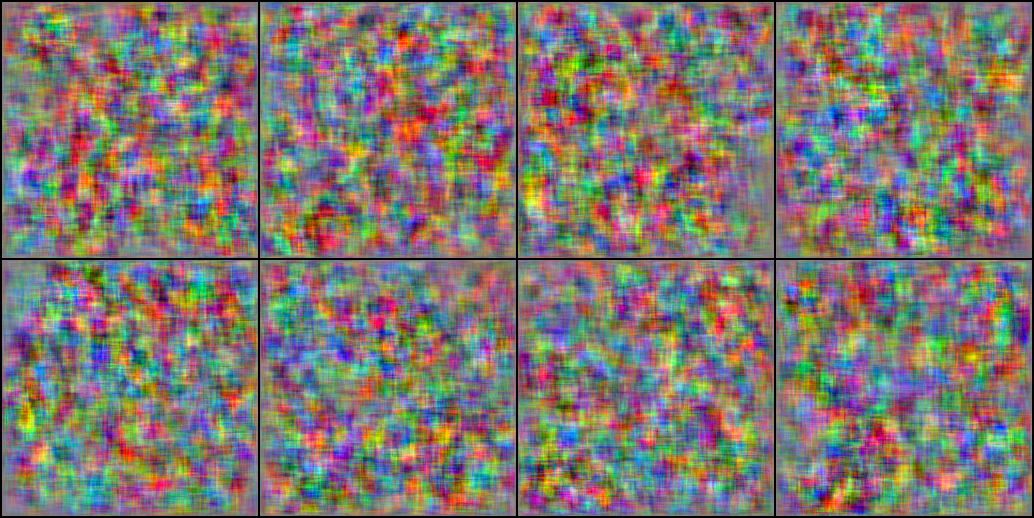

In [30]:
# Save and display images:
# save_image(sampled_images, "sample.png", nrow=int(samples_per_row), normalize=True, value_range=(-1, 1))
# samples = Image.open("sample.png")
grid = make_grid(tokens, nrow=int(samples_per_row), normalize=True, value_range=(-1, 1))
# Add 0.5 after unnormalizing to [0, 255] to round to the nearest integer
ndarr = grid.mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to("cpu", torch.uint8).numpy()
im = Image.fromarray(ndarr)
display(im)